In [2]:
from peewee import *
import base64

db = SqliteDatabase("test.db")

class Evaluations(Model):
  id = IntegerField()
  fen = TextField()
  binary = BlobField()
  eval = FloatField()

  class Meta:
    database = db

  def binary_base64(self):
    return base64.b64encode(self.binary)
db.connect()
LABEL_COUNT = 37164639
print(LABEL_COUNT)
eval = Evaluations.get(Evaluations.id == 1)
print(eval.binary_base64())

37164639
b'CAAAAAAAAAAQAAAAAAAAAIEAAAAAAAAAJAAAAAAAAABCAAAAAAAAAADvABAAAAAAAAAAAAAAAAgAAAAAAAAAEAAAAAAAAACBAAAAAAAAACQAAAAAAAAAQgAAAAAAAP8AAAABEz8='


In [3]:
import os
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
import pytorch_lightning as pl
from random import randrange


class EvaluationDataset(IterableDataset):
  def __init__(self, count):
    self.count = count
  def __iter__(self):
    return self
  def __next__(self):
    idx = randrange(self.count)
    return self[idx]
  def __len__(self):
    return self.count
  def __getitem__(self, idx):
    eval = Evaluations.get(Evaluations.id == idx+1)
    bin = np.frombuffer(eval.binary, dtype=np.uint8)
    bin = np.unpackbits(bin, axis=0).astype(np.single) 
    eval.eval = max(eval.eval, -15)
    eval.eval = min(eval.eval, 15)
    ev = np.array([eval.eval]).astype(np.single) 
    return {'binary':bin, 'eval':ev}    

dataset = EvaluationDataset(count=LABEL_COUNT)

In [ ]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',  # Replace 'val_loss' with your validation metric
    dirpath = 'lightning_logs/chessml',
    filename='{epoch}-{val_loss:.2f}',  # Save files as epoch number and validation loss
    every_n_epochs=1,  # Save every epoch
    mode='min',  # 'min' if the metric should decrease (e.g., loss), 'max' for accuracy
)


In [5]:
import time
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

torch.set_float32_matmul_precision("high")

class EvaluationModel(pl.LightningModule):
  def __init__(self,learning_rate=1e-3,batch_size=1024,layer_count=10):
    super().__init__()
    self.batch_size = batch_size
    self.learning_rate = learning_rate
    layers = []
    for i in range(layer_count-1):
      layers.append((f"linear-{i}", nn.Linear(808, 808)))
      layers.append((f"relu-{i}", nn.ReLU()))
    layers.append((f"linear-{layer_count-1}", nn.Linear(808, 1)))
    self.seq = nn.Sequential(OrderedDict(layers))

  def forward(self, x):
    return self.seq(x)

  def training_step(self, batch, batch_idx):
    x, y = batch['binary'], batch['eval']
    y_hat = self(x)
    loss = F.l1_loss(y_hat, y)
    self.log("train_loss", loss)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def train_dataloader(self):
    dataset = EvaluationDataset(count=LABEL_COUNT)
    return DataLoader(dataset, batch_size=self.batch_size, num_workers=0, pin_memory=True)  # Adjust num_workers as per your CPU

configs = [
           {"layer_count": 4, "batch_size": 512},
          #  {"layer_count": 6, "batch_size": 1024},
           ]
for config in configs:
    version_name = f'{int(time.time())}-batch_size-{config["batch_size"]}-layer_count-{config["layer_count"]}'
    logger = TensorBoardLogger("lightning_logs", name="chessml", version=version_name)
    trainer = pl.Trainer(accelerator="auto", precision="16-mixed", max_epochs=1,  logger=logger, callbacks = [checkpoint_callback])
    model = EvaluationModel(layer_count=config["layer_count"], batch_size=config["batch_size"])
    # Uncomment and use the learning rate finder if needed.
    trainer.fit(model)
    # Remove break if iterating through multiple configs.
    break

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\hacke\Documents\GitHub\4200-Chess\lightning_logs\chessml exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 2.0 M 
------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.847     Total estimated model params size (MB)
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Pyt

Epoch 0: 100%|██████████| 72588/72588 [3:50:20<00:00,  5.25it/s, v_num=nt-4]  

c:\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:383: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 72588/72588 [3:50:20<00:00,  5.25it/s, v_num=nt-4]


In [9]:
checkpoint_path = 'lightning_logs/chessml/modeltest.ckpt'


trainer.save_checkpoint(checkpoint_path)

In [11]:
checkpoint = torch.load(checkpoint_path)
print(checkpoint.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'MixedPrecision'])


In [12]:
model = EvaluationModel(layer_count=config["layer_count"], batch_size=config["batch_size"])
model.load_state_dict(checkpoint['state_dict'])
model.eval()

EvaluationModel(
  (seq): Sequential(
    (linear-0): Linear(in_features=808, out_features=808, bias=True)
    (relu-0): ReLU()
    (linear-1): Linear(in_features=808, out_features=808, bias=True)
    (relu-1): ReLU()
    (linear-2): Linear(in_features=808, out_features=808, bias=True)
    (relu-2): ReLU()
    (linear-3): Linear(in_features=808, out_features=1, bias=True)
  )
)

In [10]:
model = EvaluationModel.load_from_checkpoint(checkpoint_path)

RuntimeError: Error(s) in loading state_dict for EvaluationModel:
	Missing key(s) in state_dict: "seq.linear-4.weight", "seq.linear-4.bias", "seq.linear-5.weight", "seq.linear-5.bias", "seq.linear-6.weight", "seq.linear-6.bias", "seq.linear-7.weight", "seq.linear-7.bias", "seq.linear-8.weight", "seq.linear-8.bias", "seq.linear-9.weight", "seq.linear-9.bias". 
	size mismatch for seq.linear-3.weight: copying a param with shape torch.Size([1, 808]) from checkpoint, the shape in current model is torch.Size([808, 808]).
	size mismatch for seq.linear-3.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([808]).

Idx 7410821 Eval 0.39 Prediction 0.48 Loss 0.09
FEN rnbqk1nr/ppp2pbp/3pp1p1/8/3P1P2/4PN2/PPP3PP/RNBQKB1R w KQkq - 0 5


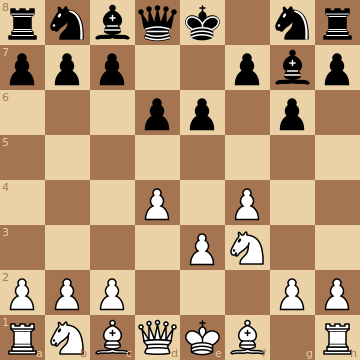

Idx 9354042 Eval 15.00 Prediction 15.11 Loss 0.11
FEN rnb2k2/pp4r1/2p1p1B1/2p3B1/2P5/2PQ4/P5PP/R5K1 b - - 0 20


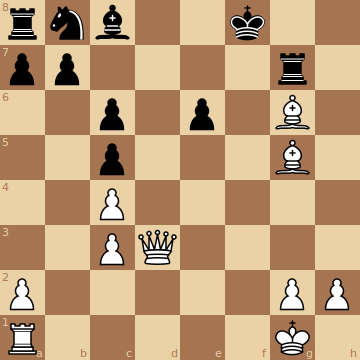

Idx 32329177 Eval 15.00 Prediction 4.41 Loss 10.59
FEN 8/8/6R1/8/5pkp/6p1/6K1/8 b - - 3 56


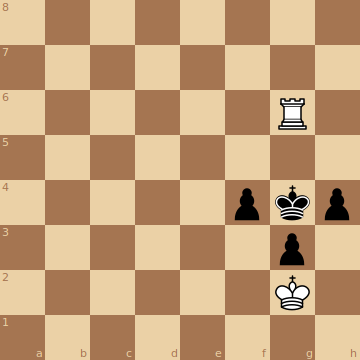

Idx 194552 Eval 1.59 Prediction -0.57 Loss 2.16
FEN rnb1k2r/pp3ppp/3p4/2p5/3N4/8/PPP1BPPP/R3K2R w KQkq c6 0 11


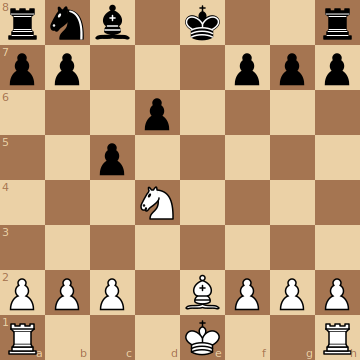

Idx 4920336 Eval 3.78 Prediction 5.58 Loss 1.80
FEN r4b1r/pp2k1pp/2np4/7q/2BP2b1/2P5/PP3PP1/RNBQR1K1 b - - 1 14


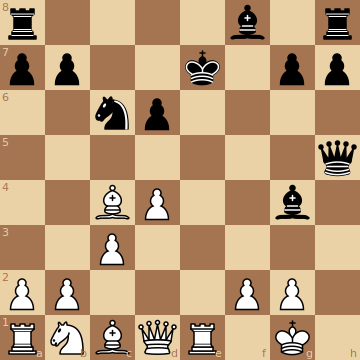

In [13]:
from IPython.display import display, SVG
from random import randrange

SVG_BASE_URL = "https://us-central1-spearsx.cloudfunctions.net/chesspic-fen-image/" 

def svg_url(fen):
  fen_board = fen.split()[0]
  return SVG_BASE_URL + fen_board

def show_index(idx):
  eval = Evaluations.select().where(Evaluations.id == idx+1).get()
  batch = dataset[idx]
  x, y = torch.tensor(batch['binary']), torch.tensor(batch['eval'])
  y_hat = model(x)
  loss = F.l1_loss(y_hat, y)
  print(f'Idx {idx} Eval {y.data[0]:.2f} Prediction {y_hat.data[0]:.2f} Loss {loss:.2f}')
  print(f'FEN {eval.fen}')
  display(SVG(url=svg_url(eval.fen)))

for i in range(5):
  idx = randrange(LABEL_COUNT)
  show_index(idx)

# need to do better on "tactics" like 700756

In [3]:
import torch
torch.cuda.is_available()

True